In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [2]:
final_pairs = pd.read_excel('final_pairs.xlsx')

In [3]:
prices = pd.read_excel('commod_data.xlsx', index_col=0)
print (prices)
returns = prices.pct_change().dropna()
#print(returns)


            CRUDOIL  GOLDBLN  LCPCASH  EIAEBRT  OILBREN  WHEATSF  LAHCASH  \
Date                                                                        
2008-08-01   123.26   914.40   8073.0   124.16   123.98     5.83  2884.45   
2008-08-04   121.41   906.20   7734.0   121.87   121.63     5.53  2831.00   
2008-08-05   119.17   880.40   7768.0   116.50   116.88     5.92  2849.50   
2008-08-06   118.58   878.40   7767.0   114.47   114.62     5.83  2855.75   
2008-08-07   120.02   872.85   7810.0   116.94   117.00     6.21  2868.25   
...             ...      ...      ...      ...      ...      ...      ...   
2022-04-25    99.49  1898.40   9783.8    99.27   102.22    10.71  3073.50   
2022-04-26   101.70  1905.32   9863.5   102.89   105.08    10.92  3048.60   
2022-04-27   102.02  1885.36   9866.5   103.30   105.33    10.90  3080.70   
2022-04-28   105.36  1887.25   9696.0   105.78   107.83    10.85  3015.50   
2022-04-29   104.69  1908.49   9770.5   108.36   107.83    10.58  3032.50   

In [7]:
def pair_trading(leg1_price,leg1_return,leg2_price,leg2_returns,window):
    
    
    #Rolling OLS hedge ratio
    endog = leg1_price
    exog = leg2_price
    rols = RollingOLS(endog, exog, window)
    rres = rols.fit()
    params = rres.params.copy()
    params.head()    
    params.tail()
    params.columns = ['Hedge ratio']
    hedge_ratio = params['Hedge ratio']
    #print (params)

    
    
    
    
    
    
    
    
    
    raw_data= leg1_price - (hedge_ratio*leg2_price)
    raw_data = pd.DataFrame(raw_data)
    raw_data.columns = ['Spread']
    raw_data = pd.concat([raw_data, leg1_price,leg2_price], axis=1)
    returns = prices.pct_change().dropna()
    
    
    raw_data['Spread_rolling_std'] = raw_data['Spread'].rolling(window).std()
    raw_data['Hedge ratio']= hedge_ratio
    raw_data['Position']=0
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*0, 'Position'] = -1
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*0, 'Position'] = 1
#     raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*1, 'Position'] = -3
#     raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-1, 'Position'] = 3
#     raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*2, 'Position'] = -5
#     raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-2, 'Position'] = 5
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*2.5, 'Position'] = 0
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-2.5, 'Position'] = 0
    
    raw_data['Position'] = raw_data['Position'] .shift(1)
    
    raw_data['Leg1_position'] = raw_data['Position']
    raw_data['Leg2_position'] = raw_data['Position']*hedge_ratio*-1
    raw_data['dailypnl'] = raw_data['Leg1_position']*leg1_return.shift(-1) + raw_data['Leg2_position'] *leg2_returns.shift(-1)
    data_2018= raw_data.loc['2018-01-01':,].copy()

    data_2018['cumpnl'] = data_2018['dailypnl'].cumsum()
    data_2018.to_csv('{}.csv'.format(X1 +"_"+ X2+"_rolling_ols"))
    data_2018['cumpnl'].plot(figsize=(10,6),label = X1 +"_"+ X2+" rolling_ols")
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.legend()
    plt.show()
    print (data_2018)
    print('Cummulative return:',data_2018['cumpnl'][-2])
    print('Sharpe ratio:',sharpe(data_2018['dailypnl']))
    print('Sortino ratio:',sortino(data_2018['dailypnl']))
    print('Max drawdown:',max_drawdown(data_2018['dailypnl']))
    
    return (data_2018)



In [5]:
def annual_returns(returns):

    num_years = len(returns) / 252

    cum_ret_final = (returns + 1).prod().squeeze()

    return cum_ret_final ** (1 / num_years) - 1
def sharpe(returns, risk_free=0):
    adj_returns = returns - risk_free
    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / np.nanstd(adj_returns, ddof=1)

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)


def sortino(returns, risk_free=0):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)

    if drisk == 0:
        return np.nan

    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / drisk

def max_drawdown(returns):
    wealth_index = 1000*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return drawdown.min()

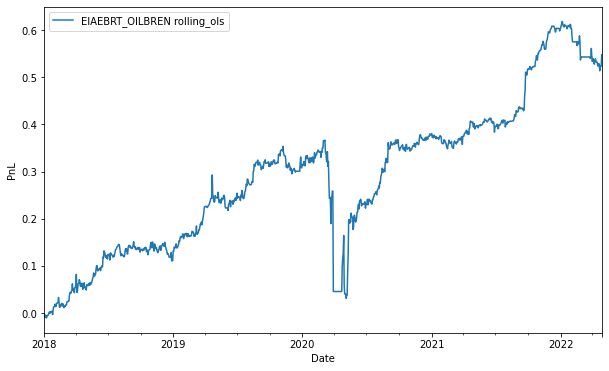

              Spread  EIAEBRT  OILBREN  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01  0.790486    66.73    66.61            0.662692     0.989934   
2018-01-02  0.960420    66.65    66.35            0.662864     0.990046   
2018-01-03  1.012538    67.85    67.50            0.663117     0.990185   
2018-01-04  1.336096    68.73    68.05            0.664227     0.990359   
2018-01-05  1.070511    68.01    67.58            0.664086     0.990522   
...              ...      ...      ...                 ...          ...   
2022-04-25 -3.952636    99.27   102.22            1.657380     1.009809   
2022-04-26 -3.202166   102.89   105.08            1.676052     1.009632   
2022-04-27 -3.027583   103.30   105.33            1.692864     1.009471   
2022-04-28 -3.053485   105.78   107.83            1.709621     1.009306   
2022-04-29 -0.471748   108.36   107.83            1.711130     1.009290   

            Position  Le

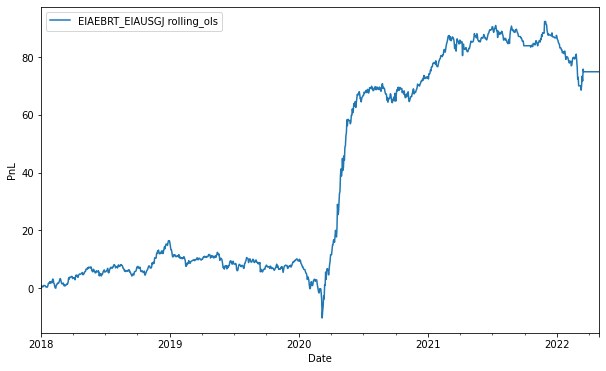

               Spread  EIAEBRT  EIAUSGJ  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   0.776443    66.73    1.904            2.939686    34.639473   
2018-01-02   0.733398    66.65    1.903            2.939556    34.638257   
2018-01-03   0.550917    67.85    1.943            2.939311    34.636687   
2018-01-04   1.983770    68.73    1.927            2.940321    34.637379   
2018-01-05   0.957184    68.01    1.936            2.938525    34.634719   
...               ...      ...      ...                 ...          ...   
2022-04-25 -48.524477    99.27    4.227            7.932040    34.964390   
2022-04-26 -54.354376   102.89    4.520            8.513232    34.788579   
2022-04-27 -62.299826   103.30    4.789            9.235347    34.579208   
2022-04-28 -68.193684   105.78    5.066           10.040325    34.341430   
2022-04-29 -46.509716   108.36    4.529           10.359764    34.195124   

           

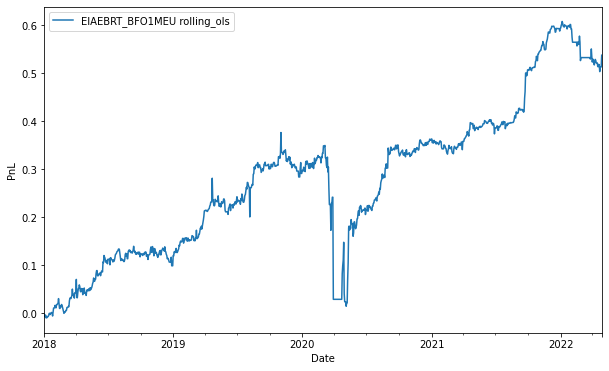

              Spread  EIAEBRT  BFO1MEU  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01  0.978847    66.73    66.61            0.640480     0.987106   
2018-01-02  1.141817    66.65    66.35            0.640037     0.987312   
2018-01-03  1.191997    67.85    67.50            0.639503     0.987526   
2018-01-04  1.511975    68.73    68.05            0.638994     0.987774   
2018-01-05  1.239915    68.01    67.58            0.637165     0.988015   
...              ...      ...      ...                 ...          ...   
2022-04-25 -3.952338    99.27   102.22            1.657550     1.009806   
2022-04-26 -3.201860   102.89   105.08            1.676223     1.009629   
2022-04-27 -3.027278   103.30   105.33            1.693038     1.009468   
2022-04-28 -3.053173   105.78   107.83            1.709796     1.009303   
2022-04-29 -0.471438   108.36   107.83            1.711306     1.009287   

            Position  Le

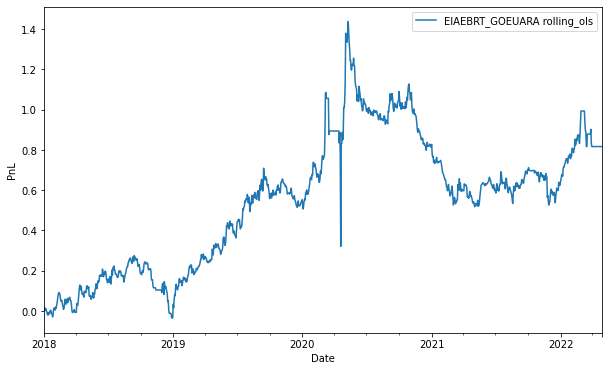

               Spread  EIAEBRT  GOEUARA  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01  -0.509821    66.73   599.00            1.106737     0.112253   
2018-01-02   0.225426    66.65   591.75            1.105903     0.112251   
2018-01-03   0.079971    67.85   603.75            1.105381     0.112248   
2018-01-04   1.072488    68.73   602.75            1.102879     0.112248   
2018-01-05   0.998514    68.01   597.00            1.100232     0.112247   
...               ...      ...      ...                 ...          ...   
2022-04-25 -27.742934    99.27  1115.50            7.001019     0.113862   
2022-04-26 -30.618636   102.89  1175.50            7.183724     0.113576   
2022-04-27 -31.645521   103.30  1191.25            7.375253     0.113281   
2022-04-28 -31.495742   105.78  1215.00            7.558950     0.112984   
2022-04-29 -30.089028   108.36  1228.50            7.717198     0.112698   

           

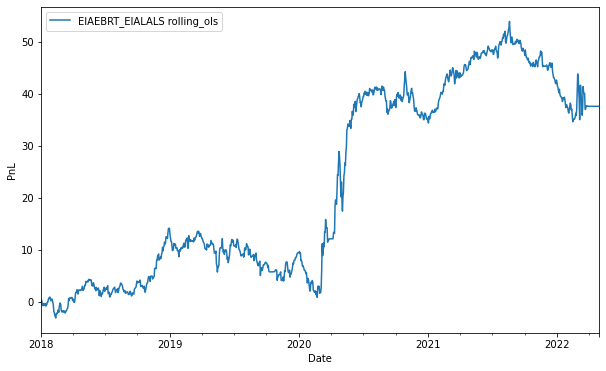

               Spread  EIAEBRT  EIALALS  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   1.272206    66.73    2.061            2.437438    31.760211   
2018-01-02   1.443648    66.65    2.053            2.437041    31.761496   
2018-01-03   1.686246    67.85    2.083            2.437388    31.763684   
2018-01-04   3.384286    68.73    2.057            2.439705    31.767484   
2018-01-05   3.481530    68.01    2.031            2.443133    31.771772   
...               ...      ...      ...                 ...          ...   
2022-04-25 -25.739990    99.27    3.874            6.208388    32.268970   
2022-04-26 -25.392975   102.89    3.983            6.373716    32.207626   
2022-04-27 -28.243296   103.30    4.093            6.575677    32.138601   
2022-04-28 -27.825302   105.78    4.166            6.764291    32.070404   
2022-04-29 -24.767520   108.36    4.159            6.904643    32.009502   

           

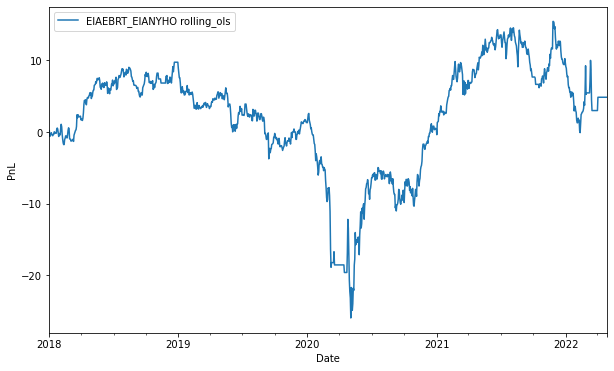

               Spread  EIAEBRT  EIANYHO  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01  -1.650197    66.73    1.993            1.411881    34.310184   
2018-01-02  -1.374762    66.65    1.983            1.413183    34.303965   
2018-01-03  -1.771969    67.85    2.030            1.416486    34.296537   
2018-01-04  -0.368862    68.73    2.015            1.413206    34.292239   
2018-01-05  -0.938191    68.01    2.011            1.409684    34.285525   
...               ...      ...      ...                 ...          ...   
2022-04-25 -44.417245    99.27    4.217            7.619483    34.073333   
2022-04-26 -50.090166   102.89    4.510            8.135357    33.920214   
2022-04-27 -58.753232   103.30    4.804            8.812680    33.732979   
2022-04-28 -64.204695   105.78    5.071            9.565653    33.520942   
2022-04-29 -42.876353   108.36    4.529            9.851094    33.392880   

           

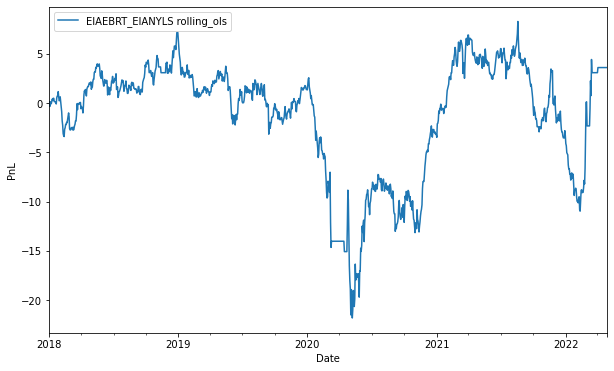

               Spread  EIAEBRT  EIANYLS  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01  -0.879706    66.73    2.068            1.692910    32.693281   
2018-01-02  -0.624407    66.65    2.058            1.691013    32.689216   
2018-01-03  -0.463242    67.85    2.090            1.689107    32.685761   
2018-01-04   0.908385    68.73    2.075            1.685598    32.685116   
2018-01-05   0.682344    68.01    2.060            1.680684    32.683328   
...               ...      ...      ...                 ...          ...   
2022-04-25 -38.552722    99.27    4.272            6.189893    32.261873   
2022-04-26 -43.206627   102.89    4.545            6.673403    32.144472   
2022-04-27 -49.966329   103.30    4.789            7.280343    32.003827   
2022-04-28 -59.585689   105.78    5.196            8.080395    31.825575   
2022-04-29 -38.326740   108.36    4.624            8.362021    31.722911   

           

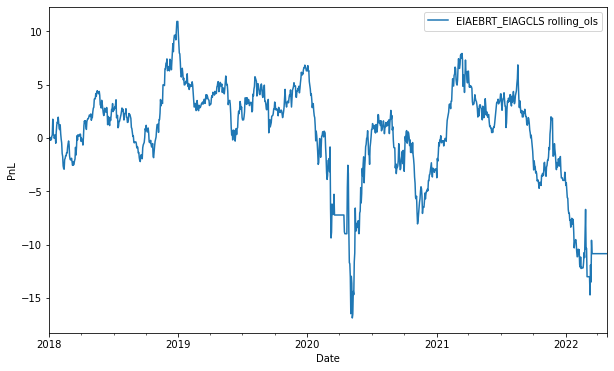

               Spread  EIAEBRT  EIAGCLS  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   1.003495    66.73    1.966            1.770383    33.431589   
2018-01-02   0.956462    66.65    1.965            1.769003    33.431826   
2018-01-03   1.982535    67.85    1.970            1.770766    33.435261   
2018-01-04   3.352280    68.73    1.955            1.778120    33.441289   
2018-01-05   2.159842    68.01    1.969            1.777786    33.443453   
...               ...      ...      ...                 ...          ...   
2022-04-25 -36.281406    99.27    4.087            5.949120    33.166481   
2022-04-26 -50.096201   102.89    4.633            6.632829    33.020980   
2022-04-27 -60.352866   103.30    4.984            7.531339    32.835647   
2022-04-28 -66.980530   105.78    5.296            8.514268    32.620946   
2022-04-29 -45.291048   108.36    4.729            8.899154    32.491235   

           

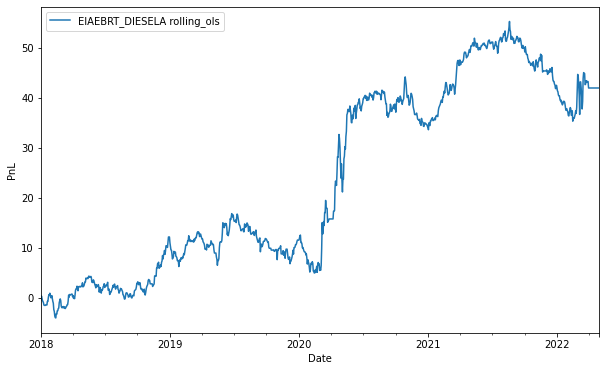

               Spread  EIAEBRT  DIESELA  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   0.948251    66.73   2.0613            2.498369    31.912749   
2018-01-02   1.705159    66.65   2.0350            2.497234    31.913927   
2018-01-03   1.388107    67.85   2.0825            2.495689    31.914475   
2018-01-04   3.064808    68.73   2.0574            2.493870    31.916590   
2018-01-05   3.331205    68.01   2.0263            2.493992    31.919654   
...               ...      ...      ...                 ...          ...   
2022-04-25 -27.179818    99.27   3.9444            6.235929    32.058062   
2022-04-26 -28.677922   102.89   4.1131            6.447412    31.987533   
2022-04-27 -31.444869   103.30   4.2227            6.696115    31.909648   
2022-04-28 -30.961912   105.78   4.2957            6.926188    31.832277   
2022-04-29 -27.864912   108.36   4.2888            7.101395    31.762944   

           

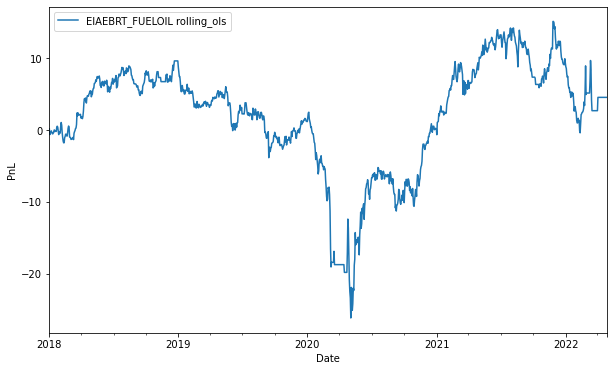

               Spread  EIAEBRT  FUELOIL  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01  -1.643513    66.73   1.9928            1.416041    34.310273   
2018-01-02  -1.357861    66.65   1.9825            1.417214    34.304091   
2018-01-03  -1.772193    67.85   2.0300            1.420452    34.296647   
2018-01-04  -0.365593    68.73   2.0149            1.417069    34.292319   
2018-01-05  -0.948492    68.01   2.0113            1.413452    34.285533   
...               ...      ...      ...                 ...          ...   
2022-04-25 -44.411044    99.27   4.2167            7.618865    34.074286   
2022-04-26 -50.094350   102.89   4.5100            8.134824    33.921142   
2022-04-27 -58.740968   103.30   4.8035            8.811816    33.733937   
2022-04-28 -64.219315   105.78   5.0713            9.565202    33.521842   
2022-04-29 -42.886880   108.36   4.5292            9.850776    33.393729   

           

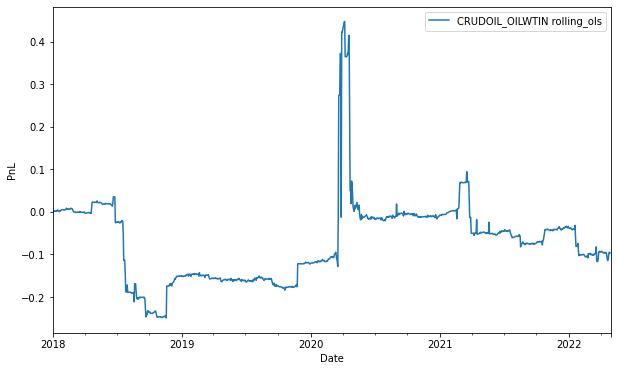

              Spread  CRUDOIL  OILWTIN  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.057989    60.42    60.46            0.108877     1.000298   
2018-01-02 -0.017889    60.37    60.37            0.108881     1.000296   
2018-01-03  0.001706    61.63    61.61            0.108875     1.000297   
2018-01-04  0.011600    62.01    61.98            0.108875     1.000297   
2018-01-05 -0.068126    61.44    61.49            0.108892     1.000295   
...              ...      ...      ...                 ...          ...   
2022-04-25 -0.090981    99.49    99.60            0.323548     0.999809   
2022-04-26 -0.894945   101.70   102.62            0.328693     0.999756   
2022-04-27  0.084432   102.02   101.96            0.328714     0.999760   
2022-04-28 -0.084228   105.36   105.47            0.328782     0.999756   
2022-04-29  0.125301   104.69   104.59            0.328727     0.999758   

            Position  Le

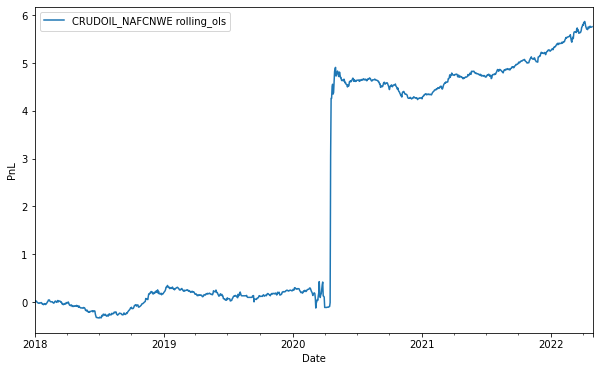

              Spread  CRUDOIL  NAFCNWE  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -1.586075    60.42    593.8            2.165986     0.104422   
2018-01-02 -1.494942    60.37    592.5            2.159675     0.104413   
2018-01-03 -0.490709    61.63    595.0            2.160340     0.104405   
2018-01-04  0.409530    62.01    590.0            2.163276     0.104408   
2018-01-05  0.041806    61.44    588.0            2.157850     0.104419   
...              ...      ...      ...                 ...          ...   
2022-04-25  8.716835    99.49    847.0            2.960473     0.107170   
2022-04-26  8.546525   101.70    868.8            3.011175     0.107221   
2022-04-27  5.811205   102.02    897.0            3.034520     0.107256   
2022-04-28  9.107715   105.36    897.0            3.088258     0.107305   
2022-04-29  6.393470   104.69    915.8            3.111735     0.107334   

            Position  Le

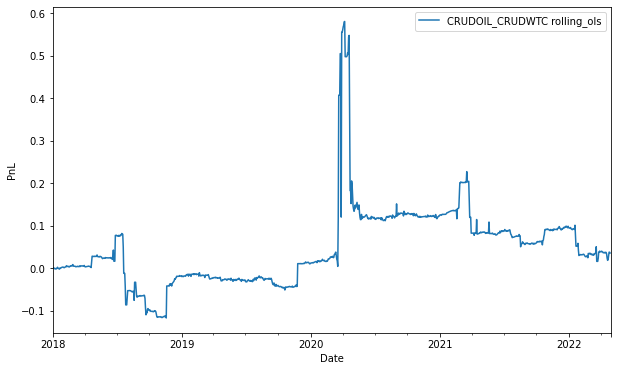

              Spread  CRUDOIL  CRUDWTC  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.061965    60.42    60.46            0.128621     1.000363   
2018-01-02 -0.021854    60.37    60.37            0.128636     1.000362   
2018-01-03 -0.002333    61.63    61.61            0.128634     1.000362   
2018-01-04  0.007543    62.01    61.98            0.128634     1.000362   
2018-01-05 -0.072144    61.44    61.49            0.128675     1.000360   
...              ...      ...      ...                 ...          ...   
2022-04-25 -0.090981    99.49    99.60            0.323548     0.999809   
2022-04-26 -0.894945   101.70   102.62            0.328693     0.999756   
2022-04-27  0.084432   102.02   101.96            0.328714     0.999760   
2022-04-28 -0.084228   105.36   105.47            0.328782     0.999756   
2022-04-29  0.125301   104.69   104.59            0.328727     0.999758   

            Position  Le

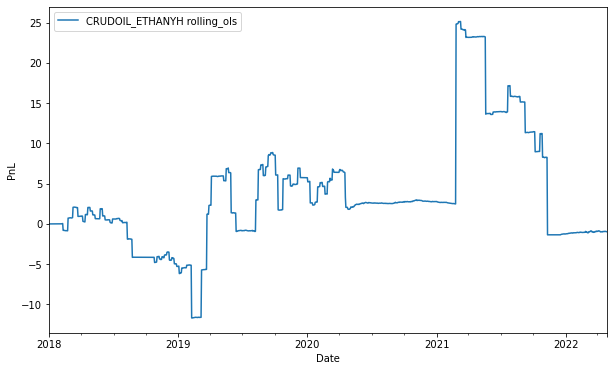

               Spread  CRUDOIL  ETHANYH  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01  15.084663    60.42     1.40            5.156467    32.382383   
2018-01-02  14.989994    60.37     1.40            5.195988    32.414290   
2018-01-03  16.201228    61.63     1.40            5.245848    32.449123   
2018-01-04  16.531559    62.01     1.40            5.297942    32.484601   
2018-01-05  15.584005    61.44     1.41            5.344521    32.521983   
...               ...      ...      ...                 ...          ...   
2022-04-25   3.413452    99.49     3.80           13.977065    25.283302   
2022-04-26   5.636911   101.70     3.80           14.009707    25.279760   
2022-04-27   5.968516   102.02     3.80           14.043598    25.276706   
2022-04-28   9.302331   105.36     3.80           14.093522    25.278334   
2022-04-29   8.632232   104.69     3.80           14.138201    25.278360   

           

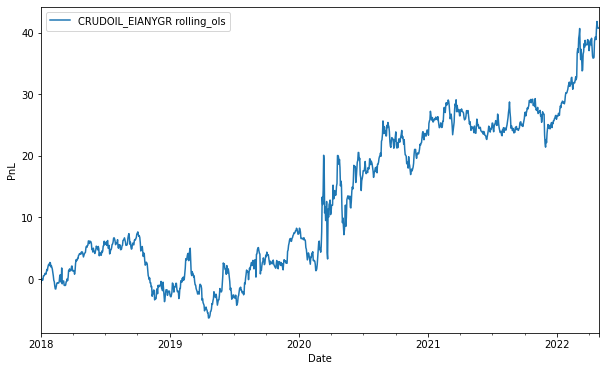

               Spread  CRUDOIL  EIANYGR  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   3.958959    60.42    1.829            4.425646    30.869897   
2018-01-02   5.033081    60.37    1.792            4.440526    30.879977   
2018-01-03   5.346321    61.63    1.822            4.456998    30.891152   
2018-01-04   5.398292    62.01    1.832            4.473029    30.901587   
2018-01-05   5.274014    61.44    1.817            4.488003    30.911385   
...               ...      ...      ...                 ...          ...   
2022-04-25  -6.030637    99.49    3.231            3.341834    32.658817   
2022-04-26  -7.574556   101.70    3.347            3.367208    32.648508   
2022-04-27 -10.039059   102.02    3.434            3.421082    32.632225   
2022-04-28  -7.608376   105.36    3.463            3.445746    32.621535   
2022-04-29  -7.268076   104.69    3.433            3.465128    32.612315   

           

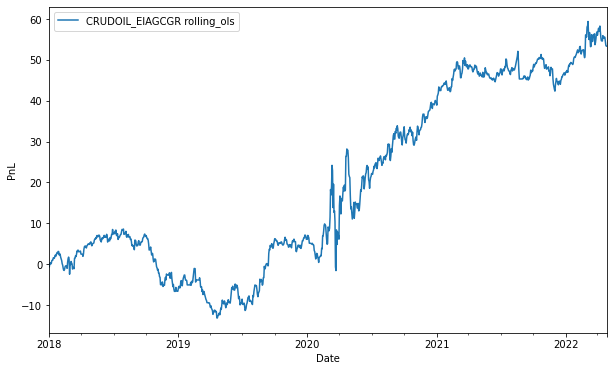

               Spread  CRUDOIL  EIAGCGR  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01   4.453684    60.42    1.769            3.733664    31.637262   
2018-01-02   5.552471    60.37    1.732            3.756323    31.649843   
2018-01-03   5.302968    61.63    1.779            3.777012    31.662187   
2018-01-04   5.346122    62.01    1.789            3.797368    31.673492   
2018-01-05   5.328411    61.44    1.771            3.816718    31.683562   
...               ...      ...      ...                 ...          ...   
2022-04-25  -6.802223    99.49    3.186            3.472617    33.362280   
2022-04-26  -8.186003   101.70    3.295            3.501035    33.349318   
2022-04-27 -10.703895   102.02    3.382            3.556085    33.330543   
2022-04-28  -8.117146   105.36    3.406            3.584823    33.316837   
2022-04-29  -8.141420   104.69    3.388            3.613680    33.303253   

           

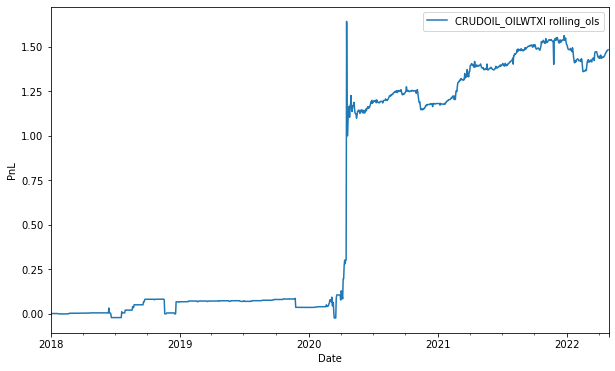

              Spread  CRUDOIL  OILWTXI  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01  0.051933    60.42    60.42            0.162106     0.999140   
2018-01-02  0.051819    60.37    60.37            0.162153     0.999142   
2018-01-03  0.051487    61.63    61.63            0.161404     0.999165   
2018-01-04  0.051719    62.01    62.01            0.161449     0.999166   
2018-01-05  0.051153    61.44    61.44            0.161492     0.999167   
...              ...      ...      ...                 ...          ...   
2022-04-25  0.745707    99.49    98.62            0.975994     1.001260   
2022-04-26 -0.137339   101.70   101.71            0.976097     1.001252   
2022-04-27 -0.196750   102.02   102.09            0.976261     1.001242   
2022-04-28  0.028170   105.36   105.20            0.976170     1.001253   
2022-04-29  0.447780   104.69   104.11            0.976242     1.001270   

            Position  Le

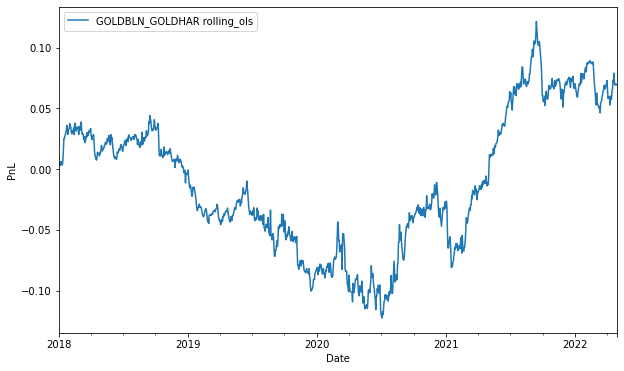

              Spread  GOLDBLN  GOLDHAR  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01  5.932888  1303.46  1296.50            3.226613     1.000792   
2018-01-02  0.024183  1313.10  1312.05            3.217074     1.000782   
2018-01-03  0.374127  1316.26  1314.90            3.132584     1.000750   
2018-01-04  2.377508  1317.88  1314.50            3.134220     1.000763   
2018-01-05  1.199500  1319.36  1317.15            3.134619     1.000767   
...              ...      ...      ...                 ...          ...   
2022-04-25  3.040993  1898.40  1895.00            5.743727     1.000189   
2022-04-26  0.350140  1905.32  1904.60            5.741442     1.000194   
2022-04-27 -0.814521  1885.36  1885.80            5.736838     1.000199   
2022-04-28 -1.617262  1887.25  1888.50            5.737355     1.000194   
2022-04-29 -3.171738  1908.49  1911.30            5.739239     1.000189   

            Position  Le

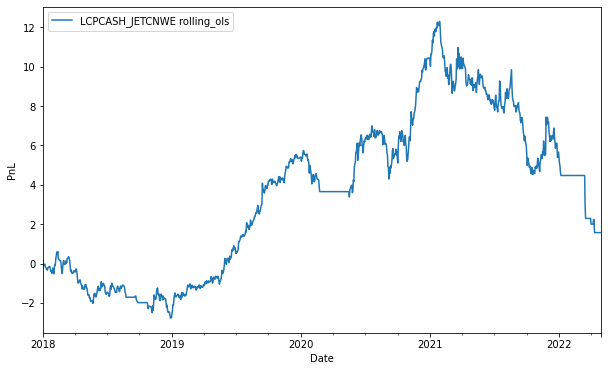

                 Spread  LCPCASH  JETCNWE  Spread_rolling_std  Hedge ratio  \
Date                                                                         
2018-01-01  -353.599549  7207.00   645.25          335.353967    11.717318   
2018-01-02  -302.480566  7160.75   637.00          336.833302    11.716218   
2018-01-03  -524.347468  7101.00   651.00          339.871732    11.713283   
2018-01-04  -466.726614  7145.75   650.00          342.185257    11.711502   
2018-01-05  -488.262886  7078.50   646.25          344.894013    11.708724   
...                 ...      ...      ...                 ...          ...   
2022-04-25 -4945.247205  9783.80  1232.25         1636.602234    11.952970   
2022-04-26 -5549.034326  9863.50  1295.75         1645.978778    11.894682   
2022-04-27 -5734.492676  9866.50  1318.25         1656.906689    11.834624   
2022-04-28 -6054.265344  9696.00  1338.00         1670.647012    11.771499   
2022-04-29 -6148.491672  9770.50  1359.75         1685.024614   

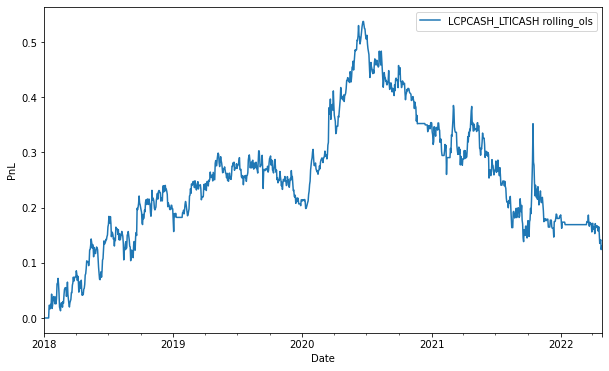

                Spread  LCPCASH  LTICASH  Spread_rolling_std  Hedge ratio  \
Date                                                                        
2018-01-01  994.248140  7207.00  20096.0          301.506767     0.309154   
2018-01-02  936.518351  7160.75  20112.0          301.266310     0.309479   
2018-01-03  916.471408  7101.00  19963.0          300.881869     0.309800   
2018-01-04  970.444811  7145.75  19910.0          299.925495     0.310161   
2018-01-05  863.818823  7078.50  20015.0          298.610503     0.310501   
...                ...      ...      ...                 ...          ...   
2022-04-25 -382.585121  9783.80  40189.0          455.829374     0.252964   
2022-04-26 -472.361220  9863.50  40898.0          459.632833     0.252723   
2022-04-27 -355.814733  9866.50  40485.0          464.528206     0.252496   
2022-04-28 -531.967673  9696.00  40545.0          468.705169     0.252262   
2022-04-29 -479.667081  9770.50  40674.0          470.782337     0.252008   

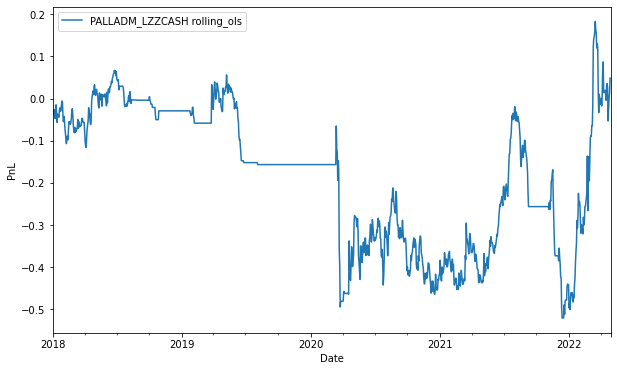

                Spread  PALLADM  LZZCASH  Spread_rolling_std  Hedge ratio  \
Date                                                                        
2018-01-01   49.707579   1056.0  3337.50           50.108739     0.301511   
2018-01-02   69.387440   1087.0  3372.50           49.838689     0.301738   
2018-01-03   75.494940   1086.0  3346.50           49.656937     0.301959   
2018-01-04   77.364178   1100.0  3384.50           49.604495     0.302153   
2018-01-05   72.941467   1095.0  3380.00           49.347464     0.302384   
...                ...      ...      ...                 ...          ...   
2022-04-25 -749.536702   2115.0  4222.75          390.743656     0.678358   
2022-04-26 -683.402913   2186.0  4241.50          389.396211     0.676507   
2022-04-27 -631.861637   2254.0  4278.00          386.907076     0.674582   
2022-04-28 -574.871941   2249.0  4197.00          384.881262     0.672831   
2022-04-29 -474.312684   2312.0  4151.25          382.356674     0.671198   

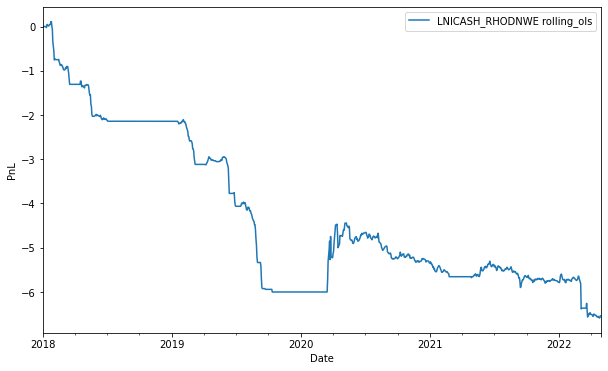

                  Spread   LNICASH  RHODNWE  Spread_rolling_std  Hedge ratio  \
Date                                                                           
2018-01-01  -2849.672416  12705.50   1705.0         1052.291267     9.123268   
2018-01-02  -2954.955659  12561.50   1705.0         1050.369750     9.100561   
2018-01-03  -3116.807818  12360.75   1705.0         1049.948965     9.077747   
2018-01-04  -2704.768870  12602.50   1690.0         1049.057031     9.057556   
2018-01-05  -2784.802565  12487.75   1690.0         1048.180000     9.037013   
...                  ...       ...      ...                 ...          ...   
2022-04-25  10253.653309  32607.00  18390.0         5781.322070     1.215516   
2022-04-26  10794.129553  33055.00  18190.0         5730.170284     1.223797   
2022-04-27  10871.734657  33281.00  18190.0         5680.173427     1.231955   
2022-04-28  10380.219720  32932.50  18190.0         5632.676404     1.239817   
2022-04-29   9025.753012  31722.00  1819

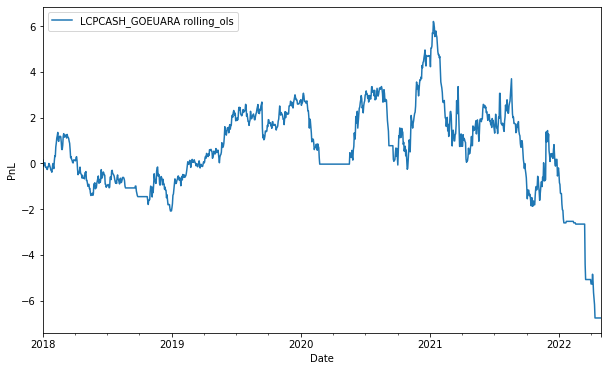

                 Spread  LCPCASH  GOEUARA  Spread_rolling_std  Hedge ratio  \
Date                                                                         
2018-01-01  -447.401084  7207.00   599.00          371.004920    12.778633   
2018-01-02  -399.792995  7160.75   591.75          373.122100    12.776583   
2018-01-03  -610.523719  7101.00   603.75          376.805610    12.772710   
2018-01-04  -551.217553  7145.75   602.75          379.829718    12.769751   
2018-01-05  -542.807926  7078.50   597.00          382.949494    12.766010   
...                 ...      ...      ...                 ...          ...   
2022-04-25 -4457.549266  9783.80  1115.50         1658.250417    12.766786   
2022-04-26 -5077.442026  9863.50  1175.50         1663.933872    12.710287   
2022-04-27 -5205.952496  9866.50  1191.25         1670.661488    12.652636   
2022-04-28 -5601.952226  9696.00  1215.00         1680.496998    12.590907   
2022-04-29 -5621.428002  9770.50  1228.50         1690.712108   

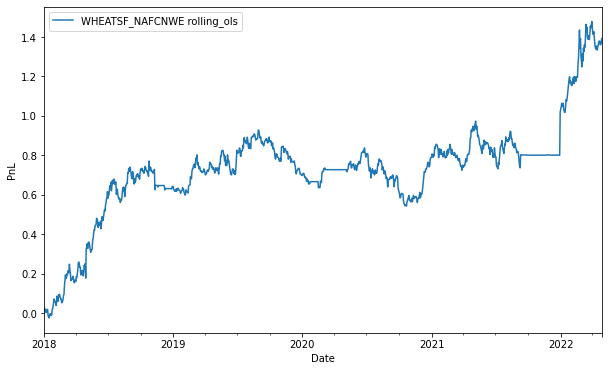

              Spread  WHEATSF  NAFCNWE  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.945319     4.32    593.8            0.703668     0.008867   
2018-01-02 -0.870207     4.38    592.5            0.702064     0.008861   
2018-01-03 -0.848343     4.42    595.0            0.701050     0.008854   
2018-01-04 -0.820094     4.40    590.0            0.700141     0.008848   
2018-01-05 -0.838484     4.36    588.0            0.699211     0.008841   
...              ...      ...      ...                 ...          ...   
2022-04-25  2.247126    10.71    847.0            1.030029     0.009992   
2022-04-26  2.234132    10.92    868.8            1.048334     0.009998   
2022-04-27  1.926974    10.90    897.0            1.063153     0.010003   
2022-04-28  1.872842    10.85    897.0            1.076803     0.010008   
2022-04-29  1.412451    10.58    915.8            1.086140     0.010010   

            Position  Le

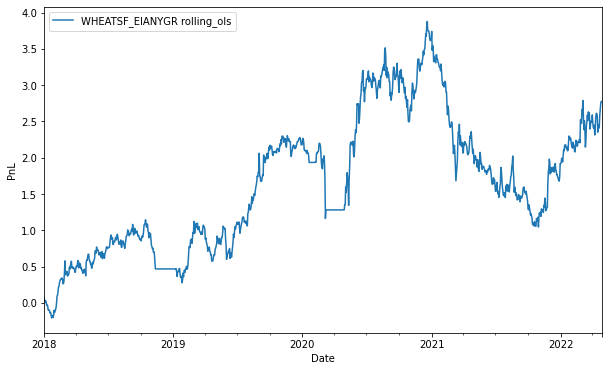

              Spread  WHEATSF  EIANYGR  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.503615     4.32    1.829            0.554371     2.637296   
2018-01-02 -0.345111     4.38    1.792            0.553312     2.636781   
2018-01-03 -0.383059     4.42    1.822            0.552346     2.636147   
2018-01-04 -0.427551     4.40    1.832            0.551907     2.635126   
2018-01-05 -0.425751     4.36    1.817            0.551827     2.633875   
...              ...      ...      ...                 ...          ...   
2022-04-25  0.859484    10.71    3.231            1.080449     3.048752   
2022-04-26  0.716841    10.92    3.347            1.084633     3.048449   
2022-04-27  0.433208    10.90    3.434            1.087034     3.047988   
2022-04-28  0.297750    10.85    3.463            1.088906     3.047141   
2022-04-29  0.122409    10.58    3.433            1.089645     3.046196   

            Position  Le

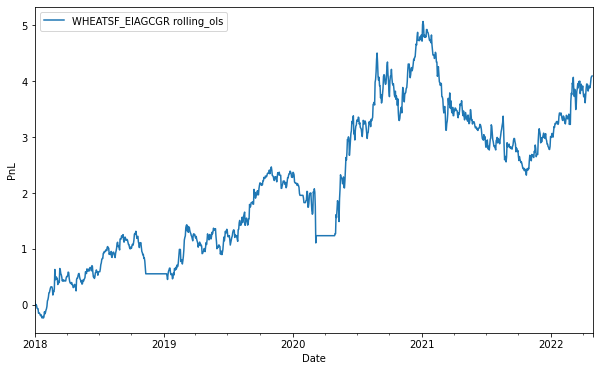

              Spread  WHEATSF  EIAGCGR  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.462711     4.32    1.769            0.530033     2.703624   
2018-01-02 -0.302143     4.38    1.732            0.528463     2.703316   
2018-01-03 -0.388190     4.42    1.779            0.527067     2.702749   
2018-01-04 -0.433447     4.40    1.789            0.526341     2.701759   
2018-01-05 -0.422559     4.36    1.771            0.526145     2.700485   
...              ...      ...      ...                 ...          ...   
2022-04-25  0.780798    10.71    3.186            1.025555     3.116510   
2022-04-26  0.652758    10.92    3.295            1.029830     3.116007   
2022-04-27  0.363873    10.90    3.382            1.032213     3.115354   
2022-04-28  0.242828    10.85    3.406            1.034237     3.114261   
2022-04-29  0.033335    10.58    3.388            1.035140     3.112947   

            Position  Le

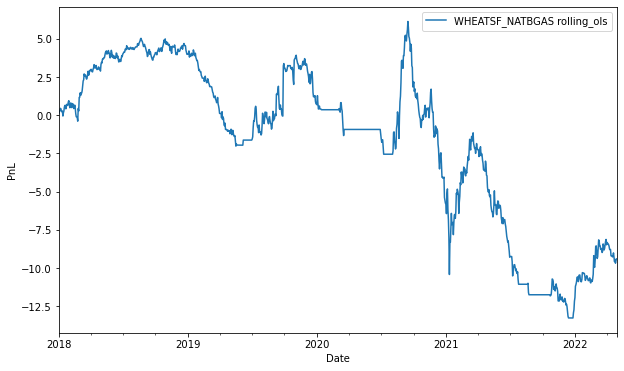

              Spread  WHEATSF   NATBGAS  Spread_rolling_std  Hedge ratio  \
Date                                                                       
2018-01-01 -1.179002     4.32  0.763357            0.968359     7.203711   
2018-01-02 -1.021795     4.38  0.750267            0.965653     7.199827   
2018-01-03 -0.897147     4.42  0.739026            0.964356     7.194804   
2018-01-04 -0.885297     4.40  0.735033            0.962566     7.190554   
2018-01-05 -0.797956     4.36  0.717618            0.960275     7.187603   
...              ...      ...       ...                 ...          ...   
2022-04-25  5.653101    10.71  1.950124            3.672385     2.593117   
2022-04-26  5.559770    10.92  2.064209            3.710670     2.596748   
2022-04-27  6.034308    10.90  1.871173            3.753612     2.600343   
2022-04-28  5.670452    10.85  1.989200            3.792473     2.603834   
2022-04-29  5.222471    10.58  2.055002            3.826854     2.607067   

           

In [8]:
#Set up the rolling period and perform rolling ols on all pairs

rollingwindow=252
for i in range(len(final_pairs)):
   
    X1 = final_pairs['Leg1'][i]
    X2 = final_pairs['Leg2'][i]
    
    
    a =pair_trading(leg1_price=prices[X1],leg1_return=returns[X1],leg2_price=prices[X2],leg2_returns=returns[X2],window=rollingwindow)
    print (X1)
    print (X2)